In [8]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import cv2
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

# A model wrapper that gets a resnet model and returns the features before the fully connected layer.
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])

    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]

resnet = torchvision.models.resnet50(pretrained=True)
resnet.eval()
model = ResnetFeatureExtractor(resnet)


def get_image_from(url):
    """A function that gets a URL of an image,
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(url))
    img = cv2.resize(img, (512, 512))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

In [12]:
car_img, car_img_float, car_tensor = get_image_from("/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl/33458386_091053535121_2.jpg")
cloud_img, cloud_img_float, cloud_tensor = get_image_from("/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl/OIP.CmONj_pGCXg9Hq9-OxTD9gHaEo.jpeg")
car_concept_features = model(car_tensor)[0, :]
cloud_concept_features = model(cloud_tensor)[0, :]
print(car_concept_features.shape, cloud_concept_features.shape)
print(car_img.shape, cloud_img.shape)

torch.Size([2048]) torch.Size([2048])
(512, 512, 3) (512, 512, 3)


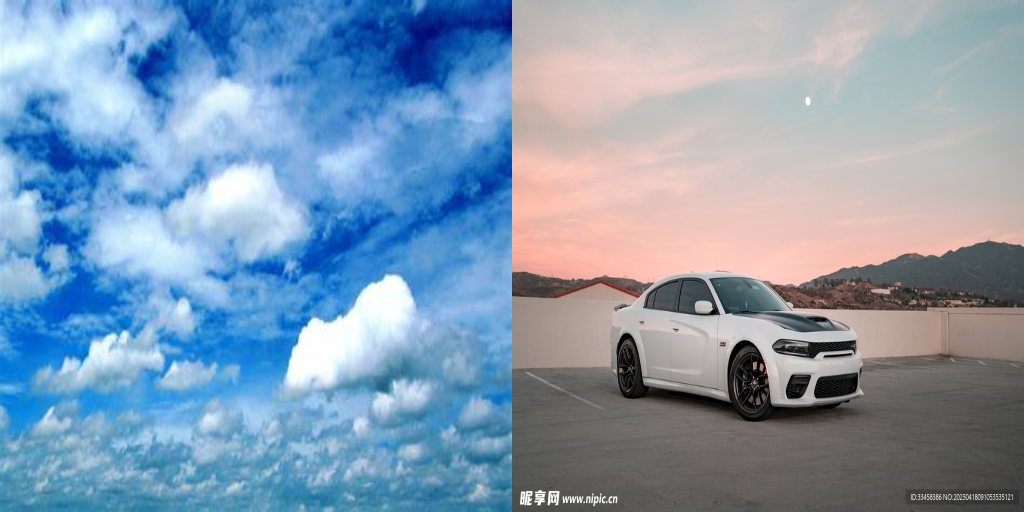

In [13]:
Image.fromarray(np.hstack((cloud_img, car_img)))

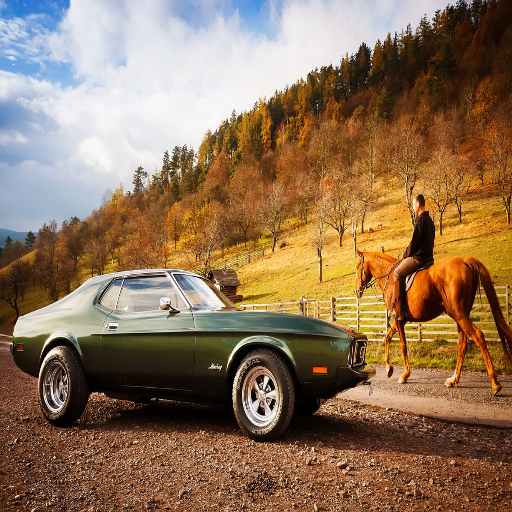

In [14]:
image, image_float, input_tensor = get_image_from("/data25/wuqin/projects/VLM2Vec/experiments/examples/qwen2vl/Pixel Attribution for embeddings_7_0.png")
Image.fromarray(image)

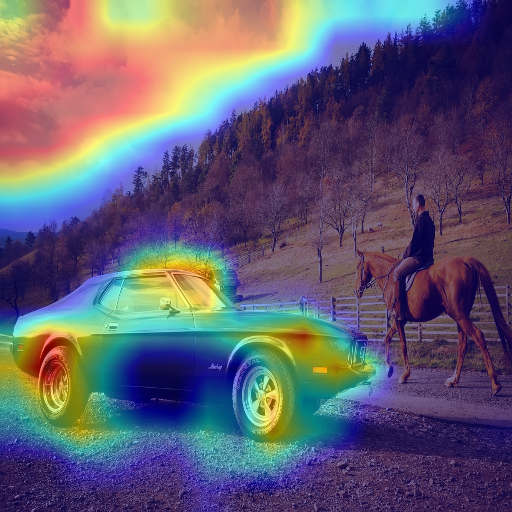

In [16]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features

    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

target_layers = [resnet.layer4[-1]]
car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

# Where is the car in the image
with GradCAM(model=model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

In [17]:
print(car_grayscale_cam.shape)

(512, 512)
